<a href="https://colab.research.google.com/github/i-bukhari/VAE-MNIST/blob/main/Variational_Autoencoder_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder (VAE) with MNIST

This notebook demonstrates how to implement a Variational Autoencoder (VAE) using PyTorch and train it on the MNIST dataset.

##Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 2. Data Preparation
Load and preprocess the MNIST dataset.



In [ ]:
# batch_size = 128
# train_dataset = (datasets
#                  .MNIST(root='./mnist_data/', train=True, transform=transforms
#                         .ToTensor(), download=True)
#                  )
# test_dataset = (datasets
#                 .MNIST(root='./mnist_data/', train=False, transform=transforms
#                        .ToTensor(), download=False)
#                 )

# train_loader = (torch.utils.data.DataLoader(dataset=train_dataset,
#                                             batch_size=batch_size,
#                                             shuffle=True)
# )
# test_loader = (torch.utils.data.DataLoader(dataset=test_dataset,
#                                            batch_size=batch_size,
#                                            shuffle=False)
# )

###Quicker MNIST

A smaller subset of the MNIST dataset for quicker iterations and reduced runtime.


In [ ]:
subset_size = 10000

train_dataset = Subset(datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True), range(subset_size))
test_dataset = Subset(datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False), range(subset_size))

batch_size = 256  # Larger batch size increases dataset efficiency
num_workers = 4  # Use multiple workers for data loading

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


###Variational Autoencoder Architecture

The following architecture was inspired by a kaggle tutorial. I choose to use this specific architecture because it uses convolutional layers, making it more suitable for image data as it can capture spatial features effectively.

In [ ]:

class VAE(nn.Module):
    def __init__(self, dim_code):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.flatten_mu = nn.Linear(128 * 7 * 7, out_features=dim_code)
        self.flatten_logsigma = nn.Linear(128 * 7 * 7, out_features=dim_code)

        # decoder
        self.decode_linear = nn.Linear(dim_code, 128 * 7 * 7)
        self.decode_2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.decode_1 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu, logsigma = self.flatten_mu(x), self.flatten_logsigma(x)
        z = self.gaussian_sampler(mu, logsigma)
        return z, mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma / 2)
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = self.decode_linear(x)
        x = x.view(x.size(0), 128, 7, 7)
        x = F.relu(self.decode_2(x))
        reconstruction = torch.sigmoid(self.decode_1(x))
        return reconstruction

    def forward(self, x):
        z, mu, logsigma = self.encode(x)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction


## Loss Functions
Based on my research, the loss of VAE is comprised of:

1. **KL-divergence**:
$$
D_{KL} = -\frac{1}{2} \sum_{i=1}^{\text{dim}Z} (1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)
$$

2. **log-likelihood**:
$$
\log p_\theta(x|z),
$$

Which together make the following **loss function**:

$$
{Loss} = -D_{KL}(q_\phi(z|x)||p(z)) + \log p_\theta(x|z)
$$

In [ ]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)


##Training and Evaluation
Implement the functions to train and evaluate the VAE model.

In [ ]:
def train_epoch(model, criterion, optimizer, data_loader):
    train_losses_per_epoch = []
    model.train()
    for x_batch, _ in data_loader:
        x_batch = x_batch.to(device)
        mu, logsigma, reconstruction = model(x_batch)
        loss = criterion(x_batch.to(device).float(), mu, logsigma, reconstruction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    return np.mean(train_losses_per_epoch)

def eval_epoch(model, criterion, optimizer, data_loader):
    val_losses_per_epoch = []
    model.eval()
    with torch.no_grad():
        for x_val, _ in data_loader:
            x_val = x_val.to(device)
            mu, logsigma, reconstruction = model(x_val)
            loss = criterion(x_val.to(device).float(), mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())
    return np.mean(val_losses_per_epoch)



##Visualization
Function to plot the real and reconstructed images for each latent dimension.

In [ ]:
def plot_output(model, test_loader, dim_code, epoch, epochs, train_loss, val_loss, size=5):
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    model.eval()
    with torch.no_grad():
        for k in range(size):
            ax = plt.subplot(2, size, k + 1)
            img = test_loader.dataset[k][0].unsqueeze(0).to(device)
            mu, logsigma, reconstruction = model(img)
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
            plt.axis('off')
            if k == size // 2:
                ax.set_title('Real')
            ax = plt.subplot(2, size, k + 1 + size)
            plt.imshow(reconstruction.cpu().squeeze().numpy(), cmap='gray')
            plt.axis('off')
            if k == size // 2:
                ax.set_title('Output')
    plt.suptitle('Latent dim: %d - Epoch %d / %d - Train loss: %f Val loss: %f' % (dim_code, epoch+1, epochs, train_loss, val_loss))
    plt.show()

##Running the Model
Train and evaluate the model for different latent dimensions and visualize the results.

In [ ]:
latent_dims = [4, 15, 50, 100]
epochs = 10
results = {}

for dim_code in latent_dims:
    print(f'\nTraining VAE with latent dimension: {dim_code}')
    criterion = loss_vae
    autoencoder_vae = VAE(dim_code).to(device)
    optimizer = torch.optim.Adam(autoencoder_vae.parameters(), lr=1e-3)
    loss = {'train_loss': [], 'val_loss': []}
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            print('* Epoch %d/%d' % (epoch+1, epochs))
            train_loss = train_epoch(autoencoder_vae, criterion, optimizer, train_loader)
            val_loss = eval_epoch(autoencoder_vae, criterion, optimizer, test_loader)
            pbar_outer.update(1)
            loss['train_loss'].append(train_loss)
            loss['val_loss'].append(val_loss)
    results[dim_code] = {'train_loss': loss['train_loss'], 'val_loss': loss['val_loss']}

    # Generate reconstructions for comparison
    autoencoder_vae.eval()
    reconstructions = []
    with torch.no_grad():
        for k in range(5):
            img = test_loader.dataset[k][0].unsqueeze(0).to(device)
            _, _, reconstruction = autoencoder_vae(img)
            reconstructions.append(reconstruction.cpu().squeeze().numpy())
    results[dim_code]['reconstructions'] = reconstructions



Training VAE with latent dimension: 4


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

* Epoch 1/10


epoch:  10%|█         | 1/10 [00:46<06:58, 46.54s/it]

* Epoch 2/10


epoch:  20%|██        | 2/10 [01:31<06:06, 45.76s/it]

* Epoch 3/10


epoch:  30%|███       | 3/10 [02:10<04:56, 42.33s/it]

* Epoch 4/10


epoch:  40%|████      | 4/10 [02:51<04:11, 41.91s/it]

* Epoch 5/10


epoch:  50%|█████     | 5/10 [03:31<03:26, 41.31s/it]

* Epoch 6/10


epoch:  60%|██████    | 6/10 [04:07<02:37, 39.41s/it]

* Epoch 7/10


epoch:  70%|███████   | 7/10 [04:42<01:54, 38.16s/it]

* Epoch 8/10


epoch:  80%|████████  | 8/10 [05:22<01:17, 38.52s/it]

* Epoch 9/10


epoch:  90%|█████████ | 9/10 [05:57<00:37, 37.67s/it]

* Epoch 10/10


epoch: 100%|██████████| 10/10 [06:33<00:00, 39.31s/it]



Training VAE with latent dimension: 15


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

* Epoch 1/10


epoch:  10%|█         | 1/10 [00:37<05:33, 37.02s/it]

* Epoch 2/10


epoch:  20%|██        | 2/10 [01:16<05:09, 38.67s/it]

* Epoch 3/10


epoch:  30%|███       | 3/10 [01:53<04:25, 37.94s/it]

* Epoch 4/10


epoch:  40%|████      | 4/10 [02:30<03:43, 37.32s/it]

* Epoch 5/10


epoch:  50%|█████     | 5/10 [03:07<03:06, 37.22s/it]

* Epoch 6/10


epoch:  60%|██████    | 6/10 [03:46<02:32, 38.03s/it]

* Epoch 7/10


epoch:  70%|███████   | 7/10 [04:24<01:53, 37.81s/it]

* Epoch 8/10


epoch:  80%|████████  | 8/10 [05:00<01:14, 37.43s/it]

* Epoch 9/10


epoch:  90%|█████████ | 9/10 [05:38<00:37, 37.33s/it]

* Epoch 10/10


epoch: 100%|██████████| 10/10 [06:17<00:00, 37.78s/it]



Training VAE with latent dimension: 50


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

* Epoch 1/10


epoch:  10%|█         | 1/10 [00:39<05:51, 39.03s/it]

* Epoch 2/10


epoch:  20%|██        | 2/10 [01:17<05:07, 38.43s/it]

* Epoch 3/10


epoch:  30%|███       | 3/10 [02:00<04:43, 40.53s/it]

* Epoch 4/10


epoch:  40%|████      | 4/10 [02:38<03:58, 39.68s/it]

* Epoch 5/10


epoch:  50%|█████     | 5/10 [03:17<03:18, 39.62s/it]

* Epoch 6/10


epoch:  60%|██████    | 6/10 [03:56<02:36, 39.09s/it]

* Epoch 7/10


epoch:  70%|███████   | 7/10 [04:35<01:57, 39.23s/it]

* Epoch 8/10


epoch:  80%|████████  | 8/10 [05:16<01:19, 39.76s/it]

* Epoch 9/10


epoch:  90%|█████████ | 9/10 [05:53<00:38, 38.79s/it]

* Epoch 10/10


epoch: 100%|██████████| 10/10 [06:30<00:00, 39.01s/it]



Training VAE with latent dimension: 100


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

* Epoch 1/10


epoch:  10%|█         | 1/10 [00:40<06:07, 40.89s/it]

* Epoch 2/10


epoch:  20%|██        | 2/10 [01:20<05:19, 39.94s/it]

* Epoch 3/10


epoch:  30%|███       | 3/10 [01:58<04:34, 39.20s/it]

* Epoch 4/10


epoch:  40%|████      | 4/10 [02:36<03:52, 38.67s/it]

* Epoch 5/10


epoch:  50%|█████     | 5/10 [03:16<03:16, 39.37s/it]

* Epoch 6/10


epoch:  60%|██████    | 6/10 [03:55<02:36, 39.01s/it]

* Epoch 7/10


epoch:  70%|███████   | 7/10 [04:31<01:54, 38.15s/it]

* Epoch 8/10


epoch:  80%|████████  | 8/10 [05:09<01:16, 38.17s/it]

* Epoch 9/10


epoch:  90%|█████████ | 9/10 [05:51<00:39, 39.15s/it]

* Epoch 10/10


epoch: 100%|██████████| 10/10 [06:30<00:00, 39.06s/it]


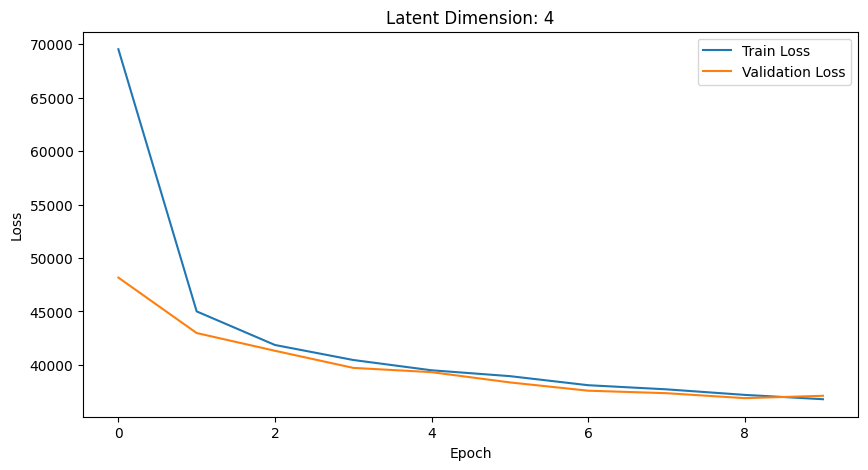

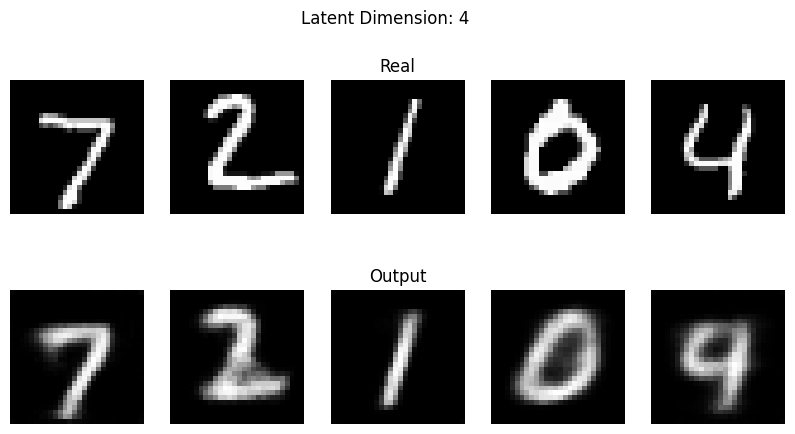

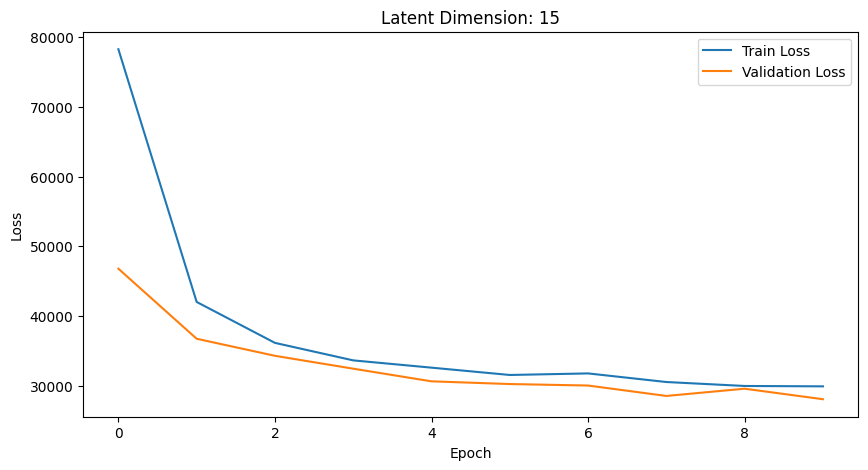

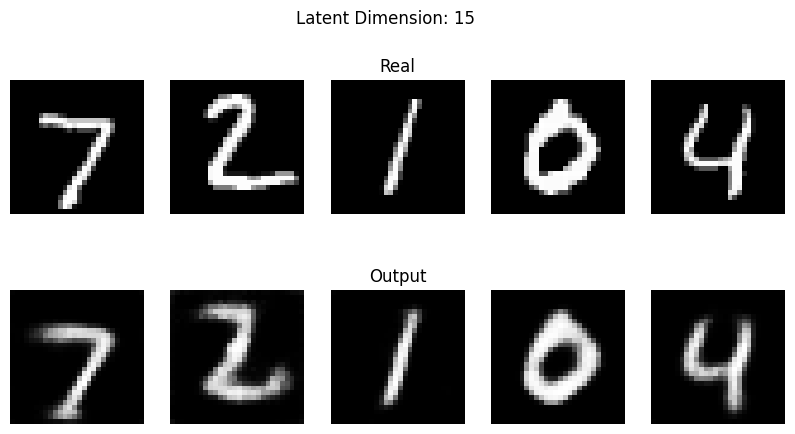

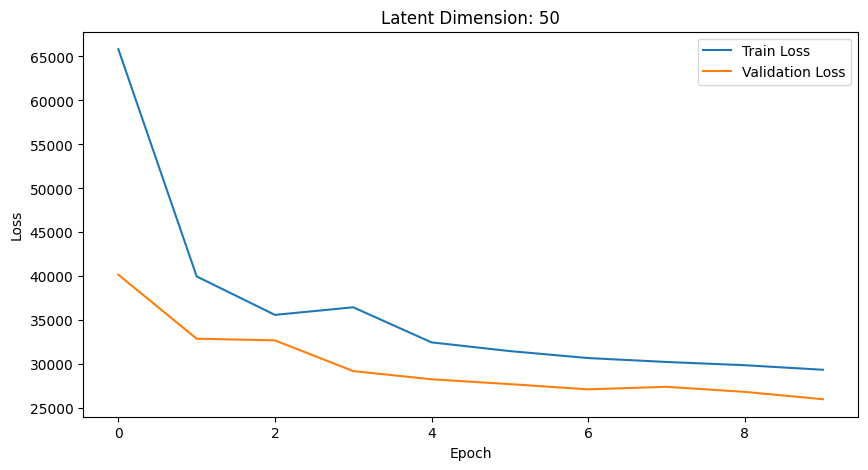

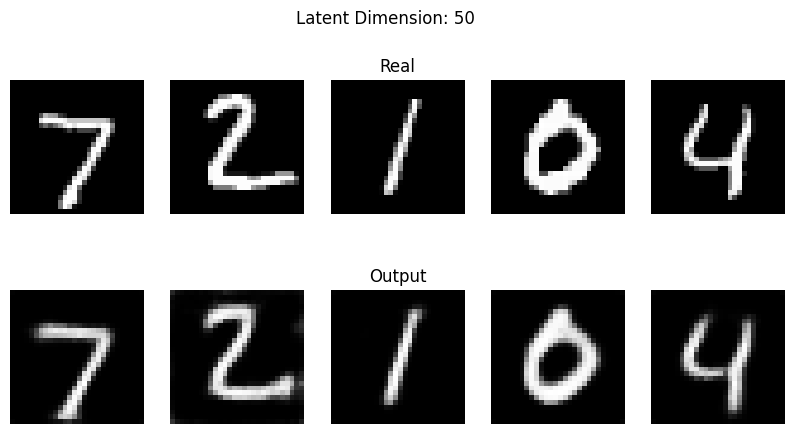

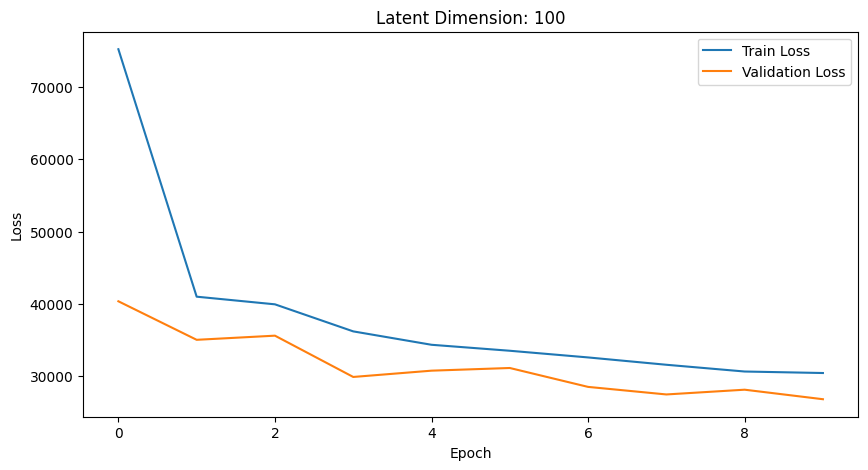

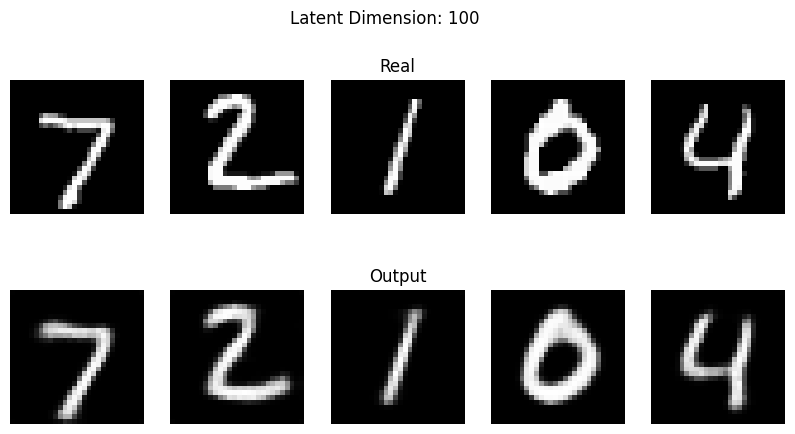

In [ ]:
# Visualize and compare results for each latent dimension
for dim_code, result in results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(result['train_loss'], label='Train Loss')
    plt.plot(result['val_loss'], label='Validation Loss')
    plt.title(f'Latent Dimension: {dim_code}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for k in range(5):
        # Real
        ax = plt.subplot(2, 5, k + 1)
        img = test_loader.dataset[k][0].unsqueeze(0).to(device)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        if k == 2:
            ax.set_title('Real')

        # Output (reconstructed image)
        ax = plt.subplot(2, 5, k + 1 + 5)
        plt.imshow(result['reconstructions'][k], cmap='gray')
        plt.axis('off')
        if k == 2:
            ax.set_title('Output')

    plt.suptitle(f'Latent Dimension: {dim_code}')
    plt.show()


## Analysis

### Summary Analysis

The results from training the Variational Autoencoder (VAE) with different latent dimensions (4, 10, 50, 100) reveal how well the model can reconstruct input images under each configuration.

With a **latent dimension of 4**, the training and validation **losses decreased** over epochs, indicating that the model was learning. However, the **loss values were relatively high**, suggesting that the model struggled to capture all necessary information with such a small latent space. The **reconstructed images were blurry** and lacked fine details, with the overall shapes of the digits somewhat preserved but significantly compromised in quality.

When using a **latent dimension of 10**, the training and validation **losses were lower** compared to the model with 4 latent dimensions, **showing improved performance**. The loss curves indicated a good learning trend, with validation loss closely following the training loss. **The reconstructed images were clearer than those with a latent dimension of 4, but still lacked some fine details**. The shapes and structures of the digits were more recognizable, though some blurriness remained.

The model with a **latent dimension of 50** achieved the **lowest training and validation losses**, indicating the best performance among the three configurations so far. The loss curves showed a consistent decrease, suggesting effective learning and good generalization. The reconstructed images were the clearest and most detailed, with the digits well-preserved and minimal blurriness, demonstrating high fidelity to the original images.

With a **latent dimension of 100**, the training and validation losses were **comparable to the model with 50 latent dimensions**, indicating similarly good performance.

In conclusion, increasing the size of the latent representation improves the VAE's ability to reconstruct input images. A latent dimension of 4 compresses the data significantly but sacrifices reconstruction quality, resulting in high losses and blurry images. A latent dimension of 10 performs better, with lower losses and clearer reconstructions, though some details are still missing. A latent dimension of 50 provides excellent balance between compression and reconstruction fidelity for the MNIST dataset, yielding the lowest losses and highest-quality reconstructions. Increasing the latent dimension to 100 provides slightly better performance, but the improvement is marginal, indicating that a latent dimension of 50 is likely sufficient for this dataset.

##Sources and Inspiration:

1. Inspiration from kaggle's [Encoders on MNIST. PyTorch](https://www.kaggle.com/code/artemsolomko/encoders-on-mnist-pytorch/notebook)

2. [Variational Autoencoder (VAE) — PyTorch Tutorial](https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjBlMzQ1ZmQ3ZTRhOTcyNzFkZmZhOTkxZjVhODkzY2QxNmI4ZTA4MjciLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDEzNTI2MDY1ODg1NDg3ODE5ODMiLCJlbWFpbCI6ImkuYnVraGFyaTk3QGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE3MjExNjUwNjMsIm5hbWUiOiJpYnJhaGltIGJ1a2hhcmkiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUNnOG9jTF9DZ0JjNGEzS0VJbjd2OWRLa0pfRHhiZ1BTMlZ3cUdCU0NiRzY5U3M4NG82dkRRPXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6ImlicmFoaW0iLCJmYW1pbHlfbmFtZSI6ImJ1a2hhcmkiLCJpYXQiOjE3MjExNjUzNjMsImV4cCI6MTcyMTE2ODk2MywianRpIjoiYjgyYmViNjc3ODlmYzBhMmEwYTIwZmJhNzllNTM5ZmJlNGI0M2E3ZCJ9.Z8mGDDE08JxlyvBN0Oppb_te1MDFWRZ4JZVQwI8kTS7xHZUT4lqFCn-QdUc7X3SXY49WJsnonL8uNY3y7MzxA9A0lrhcrwlKCO6j02DMWQL_bZEjVfIe2UFHEFQ_BqrK-sQFhbIAm0rUosm4cUQBx3ARtkWh5AOUg9bjNk3R8IycVKat67RpB-jX9kCQ2OrHseVIhoccsFEx8jEa9aO-Pr2kMqFb4RbdAJIT0hA6JVkZeF_rQYNIgFOgPWi_wHxeQtyTVIghoAheZWGexHYSnHLN_1hxiB6NjdIgC7ooRmV3rzvH7hgzWbQFfHItbbfonnZT_seG5A15-bbkSrRSZg)

3. [Github - VAE_Digit_Recognition.ipynb](https://github.com/williamcfrancis/Variational-Autoencoder-for-MNIST/blob/main/VAE_Digit_Recognition.ipynb)

4. [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)